In [82]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='paper', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

%matplotlib inline

In [207]:
def prepare_data(tms, ctd):
    ''' Procedure to calculate chi from EM-APEX float

    see: RC's write-up "EM-APEX Turbulence Measurements"
    '''
    from scipy.interpolate import interp1d

    # tms = convert_tmsdata(chi_dir)
    # tms = tms.isel(time=100)
    # tms
    # % 1) convert realtime-transmitted scaled spectrum (sla)
    # to digitized voltage Spectrum
    tms['slad1'] = (tms.sla1 - tms.logavgoff) / tms.logavgsf
    tms['slad2'] = (tms.sla2 - tms.logavgoff) / tms.logavgsf

    # % 2) convert to raw spectrum of temperature
    beta = 25
    Vref = 4  # volt
    Inet = 0.8
    scale2 = (beta * Vref / (2**23 * Inet))**2
    tms['rawTsp1'] = 10**(tms.slad1 / 10) * scale2
    tms['rawTsp2'] = 10**(tms.slad2 / 10) * scale2

    # % 3) get background T,N,P,W, and dT/dz from ctd
    tms['p'] = ctd.p.interp(time=tms.time)
    tms['N2'] = ctd.N2.interp(time=tms.time)
    tms['N'] = np.abs(np.sqrt(tms['N2']))
    tms['T'] = ctd.T.interp(time=tms.time)
    tms['dTdz'] = ctd.dTdz.interp(time=tms.time)
    tms['w'] = np.abs(ctd.w.interp(time=tms.time))

    tms['k_cpm'] = tms.f_cps / tms.w
    tms['f_rps'] = tms.f_cps * 2 * np.pi
    tms['k_rpm'] = tms.f_rps / tms.w
    tms = tms.set_coords('k_rpm')

    # % 4) compute transfer functions and compute corrected T spectrum
    tms['H2adc'] = H2ADCfun(tms.f_cps)
    tms['H2preamp'] = H2preampfun(tms.f_cps)
    tms['H2fp07'] = H2FP07fun(tms.f_cps, tms.w)
    tms['H2total_cps'] = tms.H2adc * tms.H2preamp * tms.H2fp07
    tms['corrTsp1_cps'] = tms.rawTsp1 / tms.H2total_cps
    tms['corrTsp2_cps'] = tms.rawTsp2 / tms.H2total_cps
    
    # % 5) remove noise Spectrum
    #     threshold = 4
    #     tms = remove_noise_sp(tms, threshold) 
    
    tms['snr1'] = tms.corrTsp1_cps/noise_sp(tms.f_cps)
    tms['snr2'] = tms.corrTsp2_cps/noise_sp(tms.f_cps)

    # % 6) convert temperature frequency spectrum to wavenumber Spectrum
    tms['corrTsp1_rpm'] = tms.corrTsp1_cps * tms.w / (2 * np.pi)
    tms['corrdTdzsp1_rpm'] = tms.k_rpm**2 * tms.corrTsp1_rpm

    tms['corrTsp2_rpm'] = tms.corrTsp2_cps * tms.w / (2 * np.pi)
    tms['corrdTdzsp2_rpm'] = tms.k_rpm**2 * tms.corrTsp2_rpm
    
    tms = tms.drop(
        ['slad1', 'slad2', 'rawTsp1', 'rawTsp2'])
    return tms

def compute_chi(tms):
    # % 7) compute chi, kT, and eps1
    kzmin = 20
    kzmax = 600
    D = 1.4e-7
    
    tms['noise_rpm'] = tms.k_rpm**2*noise_sp(tms.f_cps)*tms.w/(2*np.pi)
    
    tms = tms.set_coords('k_rpm').swap_dims({'f_cps': 'k_rpm'})
    condition = (tms.k_rpm <= kzmax) & (tms.k_rpm >= kzmin)

    if condition.sum() >= 3:
        tms['chi1'] = 6 * D * (tms.corrdTdzsp1_rpm - tms.noise_rpm).where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['chi2'] = 6 * D * (tms.corrdTdzsp2_rpm - tms.noise_rpm).where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['isnr1'] = tms.snr1.where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
        tms['isnr2'] = tms.snr1.where(condition).dropna(
            dim='k_rpm').integrate('k_rpm')
    else:
        tms['chi1'] = np.nan
        tms['chi2'] = np.nan
        tms['isnr1'] = np.nan
        tms['isnr2'] = np.nan
        
    return tms

def compute_rc_eps(tms):
    nu = 1.2e-6
    gamma = 0.2
    D = 1.4e-7
    
    tms['kt1'] = 0.5 * tms.chi1 / tms.dTdz**2
    tms['eps1_rc'] = tms.kt1 * tms.N2 / gamma
    tms['kb1_rc'] = (tms.eps1_rc / nu / D**2)**(0.25)
    
    tms['kt2'] = 0.5 * tms.chi2 / tms.dTdz**2
    tms['eps2_rc'] = tms.kt2 * tms.N2 / gamma
    tms['kb2_rc'] = (tms.eps2_rc / nu / D**2)**(0.25)

    return tms

def compute_goto_eps(tms):
    '''
    Method after Ruddick et al, 1996 and Goto et al., 2016
    
    Requires computation of chi.
    '''
    def cost_function(kb, k_rpm, chi, noise, corrdTdz, function):
        '''
        Cost function for MLE to fit spectra
        '''
        from scipy.stats import chi2

        kzmin = 20
        kzmax = 400
        df = 2 # %TODO: check DOF

        if function.lower() == 'batchelor':
            theory = batchelor(k_rpm.values, chi.values, kb)
        elif function.lower() == 'kraichnan':
            theory = kraichnan(k_rpm.values, chi.values, kb)
        else:
            raise ValueError('Function not known!')

        a = df / (theory + noise)
        b = chi2.pdf(corrdTdz * a, df)
        c = np.log(a * b)

        condition = (k_rpm <= kzmax) & (k_rpm >= kzmin)
        return -np.sum(c.where(condition)).values
    
    nu = 1.2e-6
    gamma = 0.2
    D = 1.4e-7
    
    args = (tms.k_rpm,tms.chi1, tms.noise_rpm, tms.corrdTdzsp1_rpm, 'Batchelor')
    tms['kb1_bat'] = minimize(cost_function, x0=340, args=args).x[0]
    tms['kb2_bat'] = minimize(cost_function, x0=340, args=args).x[0]
    
    args = (tms.k_rpm,tms.chi1, tms.noise_rpm, tms.corrdTdzsp1_rpm, 'Kraichnan')
    tms['kb1_kra'] = minimize(cost_function, x0=340, args=args).x[0]
    tms['kb2_kra'] = minimize(cost_function, x0=340, args=args).x[0]
    
    tms['eps1_bat'] = tms['kb1_bat']**4 * nu * D**2
    tms['eps2_bat'] = tms['kb2_bat']**4 * nu * D**2  #* (2 * np.pi)**4

    tms['eps1_kra'] = tms['kb1_kra']**4 * nu * D**2
    tms['eps2_kra'] = tms['kb2_kra']**4 * nu * D**2
    
    return tms

def qc_rc_eps(data):
    '''
    clean chi and eps with RC's scripts
    '''

    dtdzmin = 1.5e-3
    chimax = 5e-5
    kTmax = 1e-1
#     zmin = -10
    # for ratios
    lb = 0.5
    ub = 2

    floats = np.array([
        '7779a', '7781a', '7783a', '7786a', '7787a', '7788a',
        '7700b', '7701b','7780b', '7784b', '7785b', '7786b'
    ])
    fi = np.where(floats == data.floatid)[0][0]
    good_chi1, good_chi2 = np.load('../data/xarray/good_chi.npy')

    # 1) thresholds for chi
    data['dtdz1'] = np.sqrt(0.5 * data.chi1 / data.kt1)
    data['dtdz2'] = np.sqrt(0.5 * data.chi2 / data.kt2)

    bad = (data.dtdz1 <= dtdzmin) | (data.chi1 >= chimax) | (data.kt1 >= kTmax) #| (data.z > zmin)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    bad = (data.dtdz2 <= dtdzmin) | (data.chi2 >= chimax) | (data.kt2 >= kTmax) #| (data.z > zmin)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 2) periods of functioning chi sensor
    tmin, tmax = str2date(good_chi1[fi, 0]), str2date(good_chi1[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi1'] = data['chi1'].where(~bad)
    data['kt1'] = data['kt1'].where(~bad)
    data['eps1_rc'] = data['eps1_rc'].where(~bad)

    tmin, tmax = str2date(good_chi2[fi, 0]), str2date(good_chi2[fi, 1])
    bad = (data.time < tmin) | (data.time > tmax)
    data['chi2'] = data['chi2'].where(~bad)
    data['kt2'] = data['kt2'].where(~bad)
    data['eps2_rc'] = data['eps2_rc'].where(~bad)

    # 3) compare two sensors
    def combine_fun(array1, array2, lb=lb, ub=ub):
        ratio = array1 / array2
        bad = (ratio <= lb) | (ratio >= ub)

        chi1fin = np.isfinite(array1)
        chi2fin = np.isfinite(array2)

        a1 = np.minimum(array1.where(bad & chi1fin),
                        array2.where(bad & chi1fin))
        a2 = np.minimum(array1.where(bad & chi2fin),
                        array2.where(bad & chi2fin))
        a3 = avg_funs(array1.where(~bad), array2.where(~bad))

        concat = xr.concat([a1, a2, a3], dim='temp')
        return concat.mean(dim='temp')

    data['kT'] = combine_fun(data.kt1, data.kt2)
    data['chi'] = combine_fun(data.chi1, data.chi2)
    data['eps_rc'] = combine_fun(data.eps1_rc, data.eps2_rc)

    data = data.drop(
        ['eps1_rc', 'eps2_rc', 'kt1', 'kt2', 'dtdz1', 'dtdz2'])
    return data

def mad(tms):
    ''' Compute Maximum Absolute Deviation
    (here based on mean) and averaged for wavenumbers where SNR is large
    '''
    kzmin = 20
    kzmax = 400
    condition = (tms.k_rpm <= kzmax) & (tms.k_rpm >= kzmin)
    
    th_bat1 = batchelor(tms.k_rpm.values, tms.chi1.values, tms.kb1_bat.values) + tms.noise_rpm
    th_bat2 = batchelor(tms.k_rpm.values, tms.chi2.values, tms.kb2_bat.values) + tms.noise_rpm
    
    th_kra1 = kraichnan(tms.k_rpm.values, tms.chi1.values, tms.kb1_kra.values) + tms.noise_rpm
    th_kra2 = kraichnan(tms.k_rpm.values, tms.chi2.values, tms.kb2_kra.values) + tms.noise_rpm
    
    ratio_bat1 = (tms.corrdTdzsp1_rpm/th_bat1).where(condition)
    ratio_bat2 = (tms.corrdTdzsp1_rpm/th_bat2).where(condition)
    ratio_kra1 = (tms.corrdTdzsp1_rpm/th_kra1).where(condition)
    ratio_kra2 = (tms.corrdTdzsp1_rpm/th_kra2).where(condition)
    
    tms['mad1_bat'] = np.nanmean( np.abs( ratio_bat1  - np.nanmean(ratio_bat1)) )
    tms['mad2_bat'] = np.nanmean( np.abs( ratio_bat1  - np.nanmean(ratio_bat1)) )
    tms['mad1_kra'] = np.nanmean( np.abs( ratio_kra1  - np.nanmean(ratio_kra1)) )
    tms['mad2_kra'] = np.nanmean( np.abs( ratio_kra2  - np.nanmean(ratio_kra2)) )
    return tms

In [208]:
# l = '7786b-0200'
# chi_dir = '../data/chi/ema-'+l+'-tms.mat'
# tms = convert_tmsdata(chi_dir)
# ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
# ctd = convert_ctddata(ctd_dir)

# tms_block = tms.isel(time=30)

# tms_block = prepare_data(tms_block, ctd)
# tms_block = compute_chi(tms_block)
# tms_block = compute_rc_eps(tms_block)
# tms_block = compute_goto_eps(tms_block)
# tms_block = qc_rc_eps(tms_block)

In [209]:
# %% MAIN
liste = ['7786b-0200']
all_profiles=[]
for l in liste:
    chi_dir = '../data/chi/ema-'+l+'-tms.mat'
    tms = convert_tmsdata(chi_dir)
    ctd_dir = '../data/chi/ema-'+l+'-ctd.mat'
    ctd = convert_ctddata(ctd_dir)

    turb = []
    for jblock in range(tms.nobs.values):
        # tms = tms.isel(time=jblock)
        tms_block = tms.isel(time=jblock)
        tms_block = prepare_data(tms_block, ctd)
        tms_block = compute_chi(tms_block)
        tms_block = compute_rc_eps(tms_block)
        tms_block = compute_goto_eps(tms_block)
        tms_block = qc_rc_eps(tms_block)
        tms_block = mad(tms_block)
        tms_block = tms_block.swap_dims({'k_rpm': 'f_cps'})
        turb.append(tms_block)

    turb = xr.concat(turb, dim='time')
    all_profiles.append(turb)

all_profiles =  xr.concat(all_profiles, dim='time')
all_profiles['floatid'] = all_profiles.floatid.isel(time=0)

In [210]:
all_profiles['batchelor'] = batchelor(all_profiles.k_rpm, all_profiles.chi1, all_profiles.kb1_bat)
all_profiles['kraichnan'] = kraichnan(all_profiles.k_rpm, all_profiles.chi1, all_profiles.kb1_kra)
all_profiles['batch_rc'] = batchelor(all_profiles.k_rpm, all_profiles.chi1, all_profiles.kb1_rc)

In [211]:
hover_cols = ['eps_rc','chi1','eps_rc','eps1_bat']
arguments = {'hover_cols':hover_cols,'legend':'left','groupby':'z','loglog':True}

obs = all_profiles.hvplot(x='k_rpm',y='corrdTdzsp1_rpm',label='dT/dz',**arguments)
noi = all_profiles.hvplot(x='k_rpm',y='noise_rpm',label='Noise',line_dash='dotted',**arguments)
bat = all_profiles.hvplot(x='k_rpm',y='batchelor',label='Batchelor',**arguments)
krai = all_profiles.hvplot(x='k_rpm',y='kraichnan',label='Kraichnan',**arguments)
rc = all_profiles.hvplot(x='k_rpm',y='batch_rc',label='RC',**arguments)

In [212]:
(obs*bat*krai*rc*noi).options(height=600,ylim=(1e-9, 1e-2),
                      title=f'Temperature Gradient Spectra',
                      xlabel=r'k_z',ylabel='dPhidz')

:DynamicMap   [z]
   :Overlay
      .Curve.DT_over_dz :Curve   [k_rpm]   (corrdTdzsp1_rpm,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Batchelor  :Curve   [k_rpm]   (batchelor,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Kraichnan  :Curve   [k_rpm]   (kraichnan,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.RC         :Curve   [k_rpm]   (batch_rc,eps_rc,chi1,eps_rc,eps1_bat)
      .Curve.Noise      :Curve   [k_rpm]   (noise_rpm,eps_rc,chi1,eps_rc,eps1_bat)

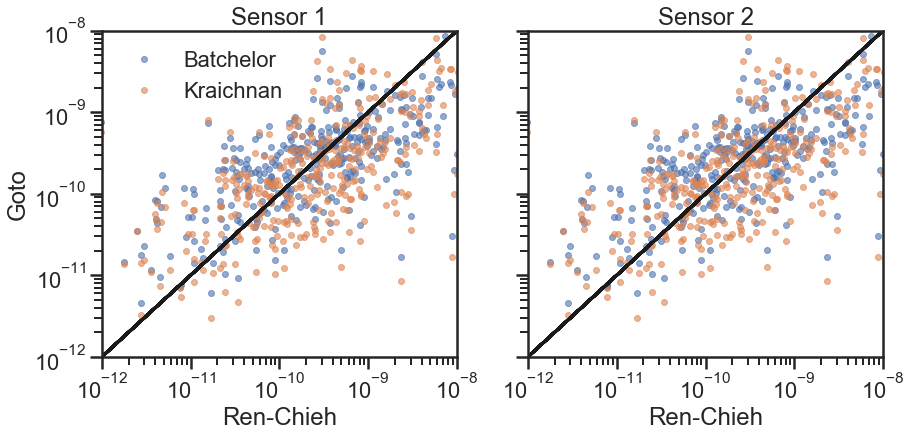

In [213]:
sns.set(context='poster',style='ticks')
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
ax[0].plot( all_profiles.eps_rc, all_profiles.eps1_bat,'.',label='Batchelor', alpha=0.6)
ax[0].plot( all_profiles.eps_rc, all_profiles.eps1_kra,'.',label='Kraichnan', alpha=0.6)

ax[0].plot( all_profiles.eps_rc, all_profiles.eps_rc, color='k')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-12,1e-8)
ax[0].set_ylim(1e-12,1e-8)
ax[0].set_xlabel('Ren-Chieh')
ax[0].set_ylabel('Goto')
ax[0].set_title(r'Sensor 1')
ax[0].legend()

ax[1].plot( all_profiles.eps_rc, all_profiles.eps2_bat,'.',label='Batchelor', alpha=0.6)
ax[1].plot( all_profiles.eps_rc, all_profiles.eps2_kra,'.',label='Kraichnan', alpha=0.6)
ax[1].plot( all_profiles.eps_rc, all_profiles.eps_rc, color='k')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-12,1e-8)
ax[1].set_ylim(1e-12,1e-8)
ax[1].set_xlabel('Ren-Chieh')
ax[1].set_title(r'Sensor 2')
plt.show()

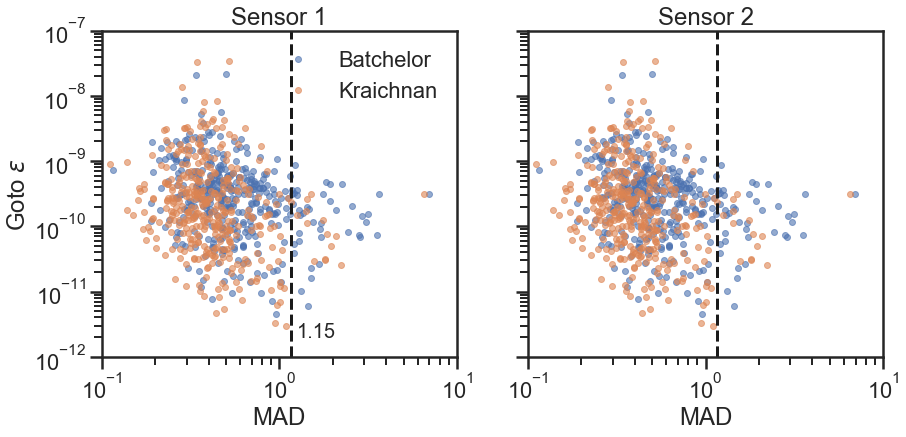

In [215]:
mad_max = 2*np.sqrt(2/6)

sns.set(context='poster',style='ticks')
f,ax = plt.subplots(1,2,figsize=(14,6), sharey =True)
ax[0].plot( all_profiles.mad1_bat, all_profiles.eps1_bat,'.',label='Batchelor', alpha=0.6)
ax[0].plot( all_profiles.mad1_kra, all_profiles.eps1_kra,'.',label='Kraichnan', alpha=0.6)


ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlim(1e-1,1e1)
ax[0].set_ylim(1e-12,1e-7)
ax[0].set_xlabel('MAD')
ax[0].set_ylabel(r'Goto $\epsilon$')
ax[0].set_title(r'Sensor 1')
ax[0].axvline(mad_max, color='k', ls='dashed')
ax[0].annotate(f'{mad_max:1.2f}',(mad_max+0.1,2e-12),fontsize=20)
ax[0].legend()

ax[1].plot( all_profiles.mad2_bat, all_profiles.eps2_bat,'.',label='Batchelor', alpha=0.6)
ax[1].plot( all_profiles.mad2_kra, all_profiles.eps2_kra,'.',label='Kraichnan', alpha=0.6)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlim(1e-1,1e1)
ax[1].set_ylim(1e-12,1e-7)
ax[1].set_xlabel('MAD')
ax[1].set_title(r'Sensor 2')
ax[1].axvline(mad_max, color='k', ls='dashed')
plt.show()